<a href="https://colab.research.google.com/github/cleber-abreu/trilha-datascience-serpro/blob/master/Tratamento_de_Dados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tratamento de Dados

# Limpeza de dados

Obtendo os dados

In [141]:
!wget 'https://moodle.ead.serpro.gov.br/moodledata-uniserpro/repository/curso_analise_dados/biblioteca/base_dados/siconv.db' --no-check-certificate

--2020-06-18 17:01:16--  https://moodle.ead.serpro.gov.br/moodledata-uniserpro/repository/curso_analise_dados/biblioteca/base_dados/siconv.db
Resolving moodle.ead.serpro.gov.br (moodle.ead.serpro.gov.br)... 161.148.24.235
Connecting to moodle.ead.serpro.gov.br (moodle.ead.serpro.gov.br)|161.148.24.235|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 154271744 (147M) [text/plain]
Saving to: ‘siconv.db.1’

siconv.db.1         100%[===================>] 147.12M  19.0MB/s    in 19s     

2020-06-18 17:01:36 (7.73 MB/s) - ‘siconv.db.1’ saved [154271744/154271744]



Leitura dos dados da tabela `"convenios"` presente na base de dados SICONV. 

Os dados estão disponíveis em formato SQLite.

In [142]:
import sqlite3
import pandas as pd

db = sqlite3.connect('siconv.db')

dados_convenios = pd.read_sql_query("SELECT * FROM convenio", db)
dados_convenios

,Ano_Convenio,Nr_Convenio,Ano_Proposta,Nr_Proposta,Tx_Modalidade,Cd_Orgao_Superior,Nm_Orgao_Superior,Cd_Orgao_Concedente,Nm_Orgao_Concedente,Tx_Esfera_Adm_Proponente,Tx_Regiao_Proponente,Uf_Proponente,Nm_Municipio_Proponente,Cd_Identif_Proponente,Nm_Proponente,Cd_Programa,Nm_Programa,Dt_Inicio_Vigencia,Dt_Fim_Vigencia,Dt_Assinatura_Convenio,Vl_Global,Vl_Repasse,Vl_Contrapartida_Total,Vl_Contrapartida_Financ,Vl_Contrapartida_Bens_Serv,Vl_Desembolsado,Vl_Empenhado,Tx_Objeto_Convenio,Tx_Justificativa,Cd_Respons_Proponente,Tx_Cargo_Respons_Proponente,Nm_Respons_Concedente,Cd_Respons_Concedente,Tx_Cargo_Respons_Concedente,Qt_Aditivos,Qt_Prorrogas,Tx_Qualific_Proponente
0,2008,700001,2008,113,Convênio,54000,MINISTERIO DO TURISMO,54000,MINISTERIO DO TURISMO,PRIVADA,Nordeste,BA,SALVADOR,550543000182,ASSOCIACAO BRASILEIRA DOS CLUBES DA MELHOR IDA...,5400020080001,Turismo Social no Brasil: Uma Viagem de Inclus...,15/09/2008,15/12/2008,15/09/2008,"110000,00","99000,00","11000,00","11000,00","0,00","0,00","99000,00",Promoção do Turismo na Bahia atraves do I Enco...,ABCMI Nacional Associação Brasileira dos Club...,21471185591,Presidente,LUIZ EDUARDO BARRETTO FILHO,07588185805,Ministro de Estado do Turismo,None,None,REPASSE_VOLUNTARIO
1,2008,700002,2008,123,Convênio,54000,MINISTERIO DO TURISMO,54000,MINISTERIO DO TURISMO,PRIVADA,Centro-Oeste,DF,BRASILIA,7359752000192,CONFEDERACAO BRASILEIRA DE CONVENTION & VISITO...,5400020080001,Turismo Social no Brasil: Uma Viagem de Inclus...,17/09/2008,28/05/2009,17/09/2008,"122222,23","110000,00","12222,23","12222,23","0,00","110000,00","110000,00",Promoção do Turismo Interno Nacionacio - BRASI...,"Brasília, a capital do país, tem lindos cartõe...",15171701687,VICE-PRESIDENTE,LUIZ EDUARDO BARRETTO FILHO,07588185805,Ministro de Estado do Turismo,None,None,REPASSE_VOLUNTARIO
2,2008,700003,2008,216,Convênio,54000,MINISTERIO DO TURISMO,54000,MINISTERIO DO TURISMO,ESTADUAL,Nordeste,CE,FORTALEZA,671077000193,SECRETARIA DO TURISMO,5400020080007,PROMOÇÃO E PARTICIPAÇÃO EM EVENTOS TURISTICOS ...,17/09/2008,30/12/2008,None,"334000,00","300000,00","34000,00","34000,00","0,00","0,00",None,O PROJETO TEM COMO OBJETO A REALIZAÇAO DO EVEN...,"O ESTADO DO CEARÁ ,É CONSIDERADO POR VELEJADOR...",54824710715,Secretario Estadual de Turismo,LUIZ EDUARDO BARRETTO FILHO,07588185805,Ministro de Estado do Turismo,None,None,REPASSE_VOLUNTARIO
3,2008,700004,2008,121,Convênio,54000,MINISTERIO DO TURISMO,54000,MINISTERIO DO TURISMO,PRIVADA,Centro-Oeste,DF,BRASILIA,7359752000192,CONFEDERACAO BRASILEIRA DE CONVENTION & VISITO...,5400020080001,Turismo Social no Brasil: Uma Viagem de Inclus...,19/09/2008,31/12/2008,19/09/2008,"444445,00","400000,00","44445,00","44445,00","0,00","400000,00","400000,00",Promoção do Turismo Nacional através da realiz...,Por se tratar dos principais eventos dos setor...,15171701687,VICE-PRESIDENTE,LUIZ EDUARDO BARRETTO FILHO,07588185805,Ministro de Estado do Turismo,None,None,REPASSE_VOLUNTARIO
4,2008,700005,2008,54,Convênio,20113,"MINISTERIO DO PLANEJAMENTO,ORCAMENTO E GESTAO",20113,"MINISTERIO DO PLANEJAMENTO,ORCAMENTO E GESTAO",PRIVADA,Sudeste,SP,SAO PAULO,96538798000107,INSTITUTO DE PESQUISAS E PROJETOS SOCIAIS E TE...,2011320080001,1008 - Inclusão Digital / Ação Observatório N...,31/10/2008,31/12/2010,31/10/2008,"777825,00","699800,00","78025,00","0,00","78025,00","699800,00","699800,00","Manutenção, aperfeiçoamento e integração do Ob...",O Observatório Nacional de Inclusão Digital - ...,04821548887,Presidente,Catarina Maria Cavalcanti de Souza Lopez,16620534449,Coordenadora Geral de Recursos Logisticos,2,None,REPASSE_VOLUNTARIO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63032,2012,769304,2012,10460,Convênio,42000,MINISTERIO DA CULTURA,20412,FUNDACAO NACIONAL DE ARTES,MUNICIPAL,Sudeste,MG,BELO HORIZONTE,7252975000156,FUNDACAO MUNICIPAL DE CULTURA,2041220120002,Fomento e Promoção a Projetos em A

Tratando dados ausentes

Substituindo vírgulas por ponto nos campos que representam números reais.

In [143]:
# colunas que possuem valores numericos
colunas_valores = dados_convenios.columns[dados_convenios.columns.str.contains('Vl_')]

In [144]:
dados_convenios[colunas_valores] = dados_convenios[colunas_valores].apply(
    lambda x: x.str.replace(',', '.', 1))

Inferencia de tipos

In [145]:
for col in colunas_valores:
  # removendo caracteres '(' ')'
  dados_convenios[col] = dados_convenios[col].str.replace('(', '', 1)
  dados_convenios[col] = dados_convenios[col].str.replace(')', '', 1)

  # removendo espaços
  dados_convenios[col] = dados_convenios[col].str.strip()
  
  # convertendo para tipo numerico
  dados_convenios[col] = pd.to_numeric(dados_convenios[col], errors='coerce')

In [146]:
dados_convenios[colunas_valores].head()

,Vl_Global,Vl_Repasse,Vl_Contrapartida_Total,Vl_Contrapartida_Financ,Vl_Contrapartida_Bens_Serv,Vl_Desembolsado,Vl_Empenhado
0,110000.00,99000.0,11000.00,11000.00,0.0,0.0,99000.0
1,122222.23,110000.0,12222.23,12222.23,0.0,110000.0,110000.0
2,334000.00,300000.0,34000.00,34000.00,0.0,0.0,NaN
3,444445.00,400000.0,44445.00,44445.00,0.0,400000.0,400000.0
4,777825.00,699800.0,78025.00,0.00,78025.0,699800.0,699800.0


Removendo colunas de dados numericos com mais de 1% de dados ausentes

In [147]:
dados_convenios.columns.size

37

In [148]:
dados_convenios = dados_convenios.loc[:, dados_convenios.isnull().sum() < 0.01*dados_convenios.shape[0]]

In [149]:
dados_convenios.columns.size

33

Substituindo dados ausentes pela média

In [150]:
# atualizando o array de colunas com valores
colunas_valores = dados_convenios.columns[dados_convenios.columns.str.contains('Vl_')]

In [151]:
# contabilizando dados ausente por coluna
dados_convenios[colunas_valores].isnull().sum()

Vl_Global                      0
Vl_Repasse                    38
Vl_Contrapartida_Total         0
Vl_Contrapartida_Financ        0
Vl_Contrapartida_Bens_Serv     0
Vl_Desembolsado                0
dtype: int64

In [152]:
dados_convenios.loc[dados_convenios['Vl_Repasse'].isnull(), 'Vl_Repasse'] = dados_convenios['Vl_Repasse'].mean()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [153]:
dados_convenios[colunas_valores].isnull().sum()

Vl_Global                     0
Vl_Repasse                    0
Vl_Contrapartida_Total        0
Vl_Contrapartida_Financ       0
Vl_Contrapartida_Bens_Serv    0
Vl_Desembolsado               0
dtype: int64

# Redução de dados

Correlação linear dos dados

In [154]:
corr = dados_convenios[colunas_valores].corr()

In [155]:
corr.style.background_gradient(cmap='coolwarm')

,Vl_Global,Vl_Repasse,Vl_Contrapartida_Total,Vl_Contrapartida_Financ,Vl_Contrapartida_Bens_Serv,Vl_Desembolsado
Vl_Global,1.000000,0.173271,0.797098,0.780352,0.171816,0.605266
Vl_Repasse,0.173271,1.000000,0.093581,0.093094,0.010263,0.290949
Vl_Contrapartida_Total,0.797098,0.093581,1.000000,0.989046,0.148181,0.425958
Vl_Contrapartida_Financ,0.780352,0.093094,0.989046,1.000000,0.000582,0.414747
Vl_Contrapartida_Bens_Serv,0.171816,0.010263,0.148181,0.000582,1.000000,0.106975
Vl_Desembolsado,0.605266,0.290949,0.425958,0.414747,0.106975,1.000000


Removendo atributos com correlação acima de 90%

In [156]:
import numpy as np

m = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.9).any()

corrFilter = corr.loc[m, m]
corrFilter.style.background_gradient(cmap='coolwarm')

,Vl_Global,Vl_Repasse,Vl_Contrapartida_Bens_Serv,Vl_Desembolsado
Vl_Global,1.000000,0.173271,0.171816,0.605266
Vl_Repasse,0.173271,1.000000,0.010263,0.290949
Vl_Contrapartida_Bens_Serv,0.171816,0.010263,1.000000,0.106975
Vl_Desembolsado,0.605266,0.290949,0.106975,1.000000


Visualização dos dados

In [157]:
dados_convenios[corrFilter.columns]

,Vl_Global,Vl_Repasse,Vl_Contrapartida_Bens_Serv,Vl_Desembolsado
0,110000.00,99000.0,0.0,0.0
1,122222.23,110000.0,0.0,110000.0
2,334000.00,300000.0,0.0,0.0
3,444445.00,400000.0,0.0,400000.0
4,777825.00,699800.0,78025.0,699800.0
...,...,...,...,...
63032,315000.00,250000.0,0.0,0.0
63033,685000.00,665000.0,0.0,0.0
63034,1000571.91,950000.0,0.0,0.0
63035,109000.00,100000.0,0.0,0.0


# Normalização e discretização

In [169]:
# Baixando o arquivo referente aos gastos com Cartão Coportativo Julho/2018
!wget 'http://www.portaltransparencia.gov.br/download-de-dados/cpgf/201807' -O CPGF.zip

#Lendo os dados do CSV e carregando no DataFrame do Pandas
dados_cpgf = pd.read_csv('CPGF.zip', compression="zip", encoding = "ISO-8859-1", sep=';')

# Pegando somente a coluna que será utilizada
dados_cpgf = dados_cpgf[['VALOR TRANSAÇÃO']]

# Convertendo coluna 'VALOR TRANSAÇÃO' para tipo númerico
dados_cpgf['VALOR TRANSAÇÃO'] = dados_cpgf['VALOR TRANSAÇÃO'].str.replace(',', '.', 1)
dados_cpgf['VALOR TRANSAÇÃO'] = pd.to_numeric(dados_cpgf['VALOR TRANSAÇÃO'])

In [159]:
dados_cpgf

,VALOR TRANSAÇÃO
0,100.00
1,49.95
2,577.73
3,450.00
4,14.48
...,...
11255,206.69
11256,235.01
11257,182.10
11258,248.67


Usar normalização min-max sobre `VALOR TRANSAÇÃO` para o intervalo [0.2, 0.8]. 

In [160]:
from sklearn.preprocessing import MinMaxScaler

In [170]:
scaler = MinMaxScaler(feature_range=(0.2, 0.8))
scaler.fit(dados_cpgf)
normalize_minmax = pd.DataFrame(scaler.transform(dados_cpgf))

In [162]:
normalize_minmax.describe()

,0
count,11260.000000
mean,0.207006
std,0.018264
min,0.200000
25%,0.201355
50%,0.203492
75%,0.208611
max,0.800000


Normalização gaussiana (Z-score) sobre `VALOR TRANSAÇÃO`

In [163]:
from scipy.stats import zscore
dados_cpgf.apply(zscore).describe()

,VALOR TRANSAÇÃO
count,1.126000e+04
mean,-1.067076e-15
std,1.000044e+00
min,-3.836305e-01
25%,-3.094166e-01
50%,-1.924372e-01
75%,8.784186e-02
max,3.246908e+01


Discretização com largura fixa de 10 intervalos sobre a coluna `VALOR TRANSAÇÃO`

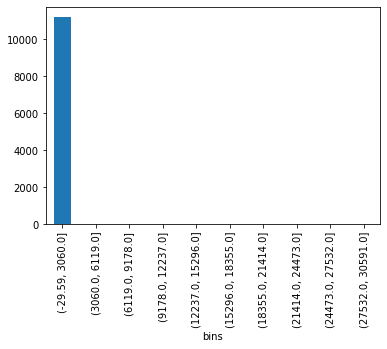

In [164]:
dados_cpgf['bins'] = pd.cut(dados_cpgf['VALOR TRANSAÇÃO'], 10)
dados_cpgf.groupby('bins')['VALOR TRANSAÇÃO'].count().plot(kind='bar')

Discretização com frequência fixa de 10 intervalos sobre a coluna `VALOR TRANSAÇÃO`

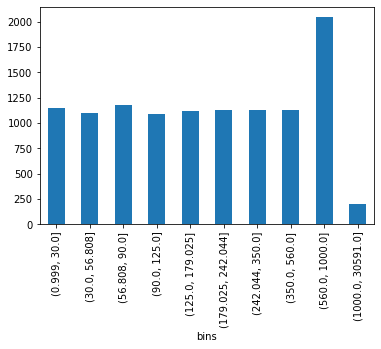

In [165]:
dados_cpgf['bins'] = pd.qcut(dados_cpgf['VALOR TRANSAÇÃO'], 10)
dados_cpgf.groupby('bins')['VALOR TRANSAÇÃO'].count().plot(kind='bar')